In [1]:
%load_ext autoreload
%autoreload 2
from calibration import Calibration
from trainer import get_trainer
import torch 
import os 
import torch.nn as nn
import torch.nn.functional as F
from trainer import DATASET_TO_PATHS, DATASET_TO_SAVE_PATHS, get_model_kwargs_from_dataset, get_training_kwargs_from_dataset
from model import PartionedCovHead
import matplotlib.pyplot as plt


/scratch/pjtka/NDSegUnc/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/scratch/pjtka/NDSegUnc/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

model_kwargs = {
    'basic':{
        'checkpoint_path': '/scratch/pjtka/nnUNet/nnUNet_results/Dataset004_TotalSegmentatorPancreas/nnUNetTrainerNoMirroring__nnUNetResEncUNetLPlans__3d_fullres/fold_0/checkpoint_best.pth',
        'loss_kwargs': {
                        'lambda_ce':1.0,
                        'lambda_dice':1.0,
                        'lambda_nll': 1.0,
                        'lambda_kl': 1e-4
                    },
        'path_to_base': '/scratch/awias/data/nnUNet/info_dict_TotalSegmentatorPancreas.pkl',
        'num_samples_train': 5,
        'num_samples_inference': 30,
        'cov_weighting_kwargs': {
            'sample_type': 'ours'
        }
    },
    'ppt': {
        'checkpoint_path': '/scratch/pjtka/nnUNet/nnUNet_results/Dataset004_TotalSegmentatorPancreas/nnUNetTrainerNoMirroring__nnUNetResEncUNetLPlans__3d_fullres/fold_0/checkpoint_best.pth',
        'loss_kwargs': {
                        'lambda_ce':1.0,
                        'lambda_dice':1.0,
                        'lambda_nll': 1.0,
                        'lambda_kl': 1e-4
                    },
        'path_to_base': '/scratch/awias/data/nnUNet/info_dict_TotalSegmentatorPancreas.pkl',
        'num_samples_train': 5,
        'num_samples_inference': 30,
        'sample_type': 'torch'
    },
    'diag': {
        'checkpoint_path': '/scratch/pjtka/nnUNet/nnUNet_results/Dataset004_TotalSegmentatorPancreas/nnUNetTrainerNoMirroring__nnUNetResEncUNetLPlans__3d_fullres/fold_0/checkpoint_best.pth',
        'loss_kwargs': {
                        'lambda_ce':1.0,
                        'lambda_dice':1.0,
                        'lambda_nll': 1.0,
                        'lambda_kl': 1e-4
                    },
        'path_to_base': '/scratch/awias/data/nnUNet/info_dict_TotalSegmentatorPancreas.pkl',
        'num_samples_train': 5,
        'num_samples_inference': 30,
        'sample_type': 'diagonal'
    },
    'multi': {
        'checkpoint_path': '/scratch/pjtka/nnUNet/nnUNet_results/Dataset004_TotalSegmentatorPancreas/nnUNetTrainerNoMirroring__nnUNetResEncUNetLPlans__3d_fullres/fold_0/checkpoint_best.pth',
        'loss_kwargs': {
                        'lambda_ce':1.0,
                        'lambda_dice':1.0,
                        'lambda_nll': 1.0,
                        'lambda_kl': 5*1e-4
                    },
        'path_to_base': '/scratch/awias/data/nnUNet/info_dict_TotalSegmentatorPancreas.pkl',
        'model_type': 'weighted_basis',
        'cov_weighting_kwargs': {
            'num_bases': 3,
            'sample_type': 'partitioned',
            'class': PartionedCovHead
        },
        'num_samples_train': 5,
        'num_samples_inference': 30
    }
}


OUTDIR = '/scratch/pjtka/ndseg_output/calibration'
training_kwargs = {
        'num_epochs': 20,
        'lr': 1e-4,
        'weight_decay': 1e-4,
        'output_dir': OUTDIR,
        'num_iterations_per_epoch': 250,
        'num_val_iterations': 5,
        'loss_kwargs': {
                        'lambda_ce': 1.0,
                        'lambda_dice': 1.0,
                        'lambda_nll': 1.0,
                        'lambda_kl': 1e-4
                    },

        'tau_schedule': {'type': 'constant', 'max': 2, 'min': 0.1},

        'eval_loader_data_path': '/scratch/pjtka/pancreas_validation',
        'test_loader_data_path': '/scratch/pjtka/pancreas_test',
        'gradient_accumulation': False,
        'recreate_dataset': False
    }


dataset_method_to_pretrained = {
    'pancreas': {
        'basic': '/scratch/pjtka/ndseg_output/pancreas_final_run/exp_basic_run_4_model_epoch_10.pth',
        'multi': '/scratch/pjtka/ndseg_output/pancreas_final_run/exp_multi_basis_proper_gumbel_run_1_model_epoch_18.pth',
        'diag': '/scratch/pjtka/ndseg_output/pancreas_final_run/exp_diag_run_0_model_epoch_8.pth',
        'ppt': '/scratch/pjtka/ndseg_output/pancreas_final_run/exp_ppt_run_1_model_epoch_5.pth',
        } 
}

import copy
def get_trainer_from_name(name = 'basic', dataset = 'pancreas', checkpoint = True):
    model_kwargs_ = model_kwargs[name]
    model_kwargs_ = get_model_kwargs_from_dataset(dataset=dataset, current_kwargs=copy.deepcopy(model_kwargs_))
    training_kwargs_ = get_training_kwargs_from_dataset(dataset = dataset, current_kwargs=copy.deepcopy(training_kwargs))

    if checkpoint:
        model_kwargs_['checkpoint_path'] = dataset_method_to_pretrained[dataset][name]
    return get_trainer(model_kwargs_, training_kwargs_)




In [3]:
%%capture
name_to_calib = {'Base Model': None, 'Diag': None,'Diag + Lowrank': None, 'Single Basis': None, 'Mixture-of-Bases': None}
key_to_name = {'Diag': 'diag', 'Diag + Lowrank': 'ppt', 'Single Basis': 'basic', 'Mixture-of-Bases': 'multi', 'Base Model': 'basic'}

for idx, key in enumerate(name_to_calib.keys()):
    trainer = get_trainer_from_name(name = key_to_name[key])
    if idx == 0:
        dataset = trainer.test_loader
    
    if key == 'Base Model':
        base_model = copy.deepcopy(trainer.model)
        base_model.basis_model_only(True)
        name_to_calib['Base Model'] = Calibration(dataset, base_model)
        name_to_calib['Base Model'].predict(max_idx = 15)

    name_to_calib[key] = Calibration(dataset, trainer.model)
    name_to_calib[key].predict(max_idx = 30)
    name_to_calib[key].model.to('cpu')


In [4]:

trainer = get_trainer_from_name(name = 'basic', checkpoint=False)

Using the following paths
{'checkpoint_path': '/scratch/pjtka/nnUNet/nnUNet_results/Dataset004_TotalSegmentatorPancreas/nnUNetTrainerNoMirroring__nnUNetResEncUNetLPlans__3d_fullres/fold_0/checkpoint_best.pth',
 'dataset_name_or_id': '004',
 'path_to_base': '/scratch/awias/data/nnUNet/info_dict_TotalSegmentatorPancreas.pkl'}
Using the following paths
{'eval_loader_data_path': '/scratch/pjtka/pancreas_validation',
 'test_loader_data_path': '/scratch/pjtka/pancreas_test'}
/scratch/pjtka/ndseg_output/calibration
standard_uncertainty
{'num_samples_train': 5, 'num_samples_inference': 30, 'cov_weighting_kwargs': {'sample_type': 'ours'}}
Loss initialized with ce: 1.0 dice: 1.0 kl: 0.0001
Starting from checkpoint /scratch/pjtka/nnUNet/nnUNet_results/Dataset004_TotalSegmentatorPancreas/nnUNetTrainerNoMirroring__nnUNetResEncUNetLPlans__3d_fullres/fold_0/checkpoint_best.pth
_IncompatibleKeys(missing_keys=['cov_basis_mat', 'decoder.diag_head.weight', 'decoder.diag_head.bias', 'decoder.cov_head.weig

In [5]:
trainer.model.basis_model_only(True)
name_to_calib['Base Model'] = Calibration(dataset, trainer.model)


In [6]:
name_to_calib['Base Model'].predict(15)

predicting:   9%|█████████▊                                                                                                | 15/163 [00:04<00:42,  3.47it/s]


(0.014522585086524487,
 0.4328441321849823,
 [tensor(2.7473e-10),
  tensor(0.8332),
  tensor(0.8980),
  tensor(0.8807),
  tensor(0.9391),
  tensor(0.8943),
  tensor(0.9387),
  tensor(0.9283),
  tensor(0.9544),
  tensor(0.9639),
  tensor(0.9319),
  tensor(0.9132),
  tensor(0.9386),
  tensor(0.9369),
  tensor(1.7857e-08),
  tensor(0.7091)])

In [7]:
name_to_calib['Deterministic'] = name_to_calib.pop('Base Model')
name_to_calib['Diagonal'] = name_to_calib.pop('Diag')

name_to_calib['Diag + LowRank'] = name_to_calib.pop('Diag + Lowrank')


In [8]:
%matplotlib inline

fig, ax = plt.subplots(1,1)

x_y_key = {}
for key, calib in name_to_calib.items():
        ax, x, y = calib.visualize(ax=ax,
                n_bins=15,
                label=key,
                binning="uniform",
                accuracy_mode="empirical",
                threshold=0.5,
                show_counts=False,
                return_numbers = True, 
                )
        x_y_key[key] = (x, y)


font = {"fontname": "Times New Roman"}  # ensure Times New Roman
ax.set_xlabel("Confidence (mean predicted probability)", fontsize=18, **font)
ax.set_ylabel("Fraction of Postives", fontsize=18, **font)
ax.set_title("Calibration Pancreas", fontsize=20, **font)
legend = copy.deepcopy(ax.get_legend_handles_labels)
ax.legend_ = None
ax.legend(legend)
ax.grid(alpha = 0.2, linewidth = 2)
plt.show()

TypeError: 'method' object is not iterable

In [16]:
import json 
import pickle
with open('/home/pjtka/ndsegment/nnUNet_v2/calibration_data.pkl', 'wb') as handle:
    pickle.dump(x_y_key, handle, protocol = pickle.HIGHEST_PROTOCOL)

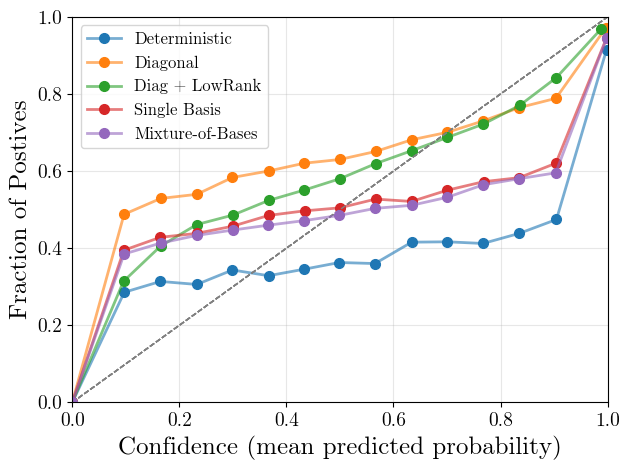

In [18]:
import matplotlib.pyplot as plt 
import pickle
import matplotlib.colors as mcolors
fig, ax = plt.subplots(1,1)
# plt.rcParams.update({
#     "text.usetex": False,  # don’t call LaTeX
#     "font.family": "serif",
#     "font.serif": ["CMU Serif"],  # Computer Modern lookalike
# })


import matplotlib.font_manager as fm

# Point to the TTF file you downloaded
font_path = "/home/pjtka/ndsegment/nnUNet_v2/cmunrm.otf"
cmu_font = fm.FontProperties(fname=font_path, size = 12)
x_y_key = pickle.load(open('/home/pjtka/ndsegment/nnUNet_v2/calibration_data.pkl', 'rb'))
keys = ['Deterministic', 'Diagonal', 'Diag + LowRank', 'Single Basis', 'Mixture-of-Bases']
for key in keys:
    (x, y) = x_y_key[key]
    ax.plot([0.0, 1.0], [0.0, 1.0], linestyle="--", linewidth=1.0, color="gray", label="_nolegend_")
    line, = ax.plot(x, y, marker="o", linestyle="-", label=key, markersize = 7, linewidth = 2)


    # Extract the line color as RGBA
    color = mcolors.to_rgba(line.get_color())

    # Make a transparent version for the line
    line.set_color((color[0], color[1], color[2], 0.6))  # line alpha=0.3

    # Keep markers fully opaque
    line.set_markerfacecolor((color[0], color[1], color[2], 1.0))
    line.set_markeredgecolor((color[0], color[1], color[2], 1.0))

ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)




font = {"fontname": "Times New Roman"}  # ensure Times New Roman
ax.set_xlabel("Confidence (mean predicted probability)", fontproperties = cmu_font, fontsize=18)
ax.set_ylabel("Fraction of Postives",fontproperties = cmu_font, fontsize=18)
ax.grid(alpha=0.3)
# ax.tick_params(axis='both', which='major', labelsize=20)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(cmu_font)
    label.set_size(14)

ax.set_title("")
ax.legend(prop=cmu_font.copy(), loc = 'upper left')
fig.tight_layout()
# plt.savefig("figure.pdf", bbox_inches="tight", pad_inches=0.05)
fig.savefig('/home/pjtka/ndsegment/nnUNet_v2/calibration.pdf', format = 'pdf', bbox_inches = 'tight', pad_inches = 0.05)
plt.show()



In [46]:
cal = name_to_calib['Mixture-of-Bases']

In [69]:

from torchmetrics.classification import BinaryCalibrationError
import numpy as np 

def sample_evenly(cal):

    preds, labels = [], []
    num_positives = torch.sum(cal.labels == 1).item()
    for cls_ in range(2):
        indices_cls = torch.where(cal.labels == cls_)[0].numpy()
        chosen = torch.from_numpy(np.random.choice(indices_cls, size = (num_positives, ), replace = False))

        preds.append(cal.probs[chosen])
        labels.append(cal.labels[chosen])
    
    preds = torch.cat(preds)
    labels = torch.cat(labels)

    ece_metric = BinaryCalibrationError(n_bins=10, norm='l1')
    mce_metric = BinaryCalibrationError(n_bins=10, norm='max')

    ece = ece_metric(preds, labels).item()
    mce = mce_metric(preds, labels).item()
    return mce, ece


res = {}
for key, val in name_to_calib.items():
    print(key, val.mce)
    print(key, val.ece)



    

        
    

Single Basis 0.31891563534736633
Single Basis 0.01761285588145256
Mixture-of-Bases 0.3176155686378479
Mixture-of-Bases 0.01778731495141983
Deterministic 0.4328441321849823
Deterministic 0.014522585086524487
Diagonal 0.3901907205581665
Diagonal 0.01879296638071537
Diag + LowRank 0.2464742660522461
Diag + LowRank 0.012804193422198296


In [67]:
for key, val in res.items():
    for k, v in val.items():
        if k != 'std':
            print(key,k ,f"${np.mean(v):.03f} \\pm {val['std']:.02f}$")

Single Basis mce $0.319 \pm 0.00$
Single Basis ece $0.050 \pm 0.00$
Mixture-of-Bases mce $0.318 \pm 0.00$
Mixture-of-Bases ece $0.048 \pm 0.00$
Deterministic mce $0.433 \pm 0.00$
Deterministic ece $0.034 \pm 0.00$
Diagonal mce $0.390 \pm 0.00$
Diagonal ece $0.081 \pm 0.00$
Diag + LowRank mce $0.246 \pm 0.00$
Diag + LowRank ece $0.075 \pm 0.00$


In [60]:
res

{'Single Basis': {'mce': 0.31891563534736633,
  'ece': 0.09747713059186935,
  'std': np.float64(0.0)},
 'Mixture-of-Bases': {'mce': 0.3176155686378479,
  'ece': 0.09549212455749512,
  'std': np.float64(0.0)},
 'Deterministic': {'mce': 0.4328441321849823,
  'ece': 0.07987254858016968,
  'std': np.float64(0.0)},
 'Diagonal': {'mce': 0.3901907205581665,
  'ece': 0.1392982453107834,
  'std': np.float64(0.0)},
 'Diag + LowRank': {'mce': 0.2464742660522461,
  'ece': 0.14088746905326843,
  'std': np.float64(0.0)}}